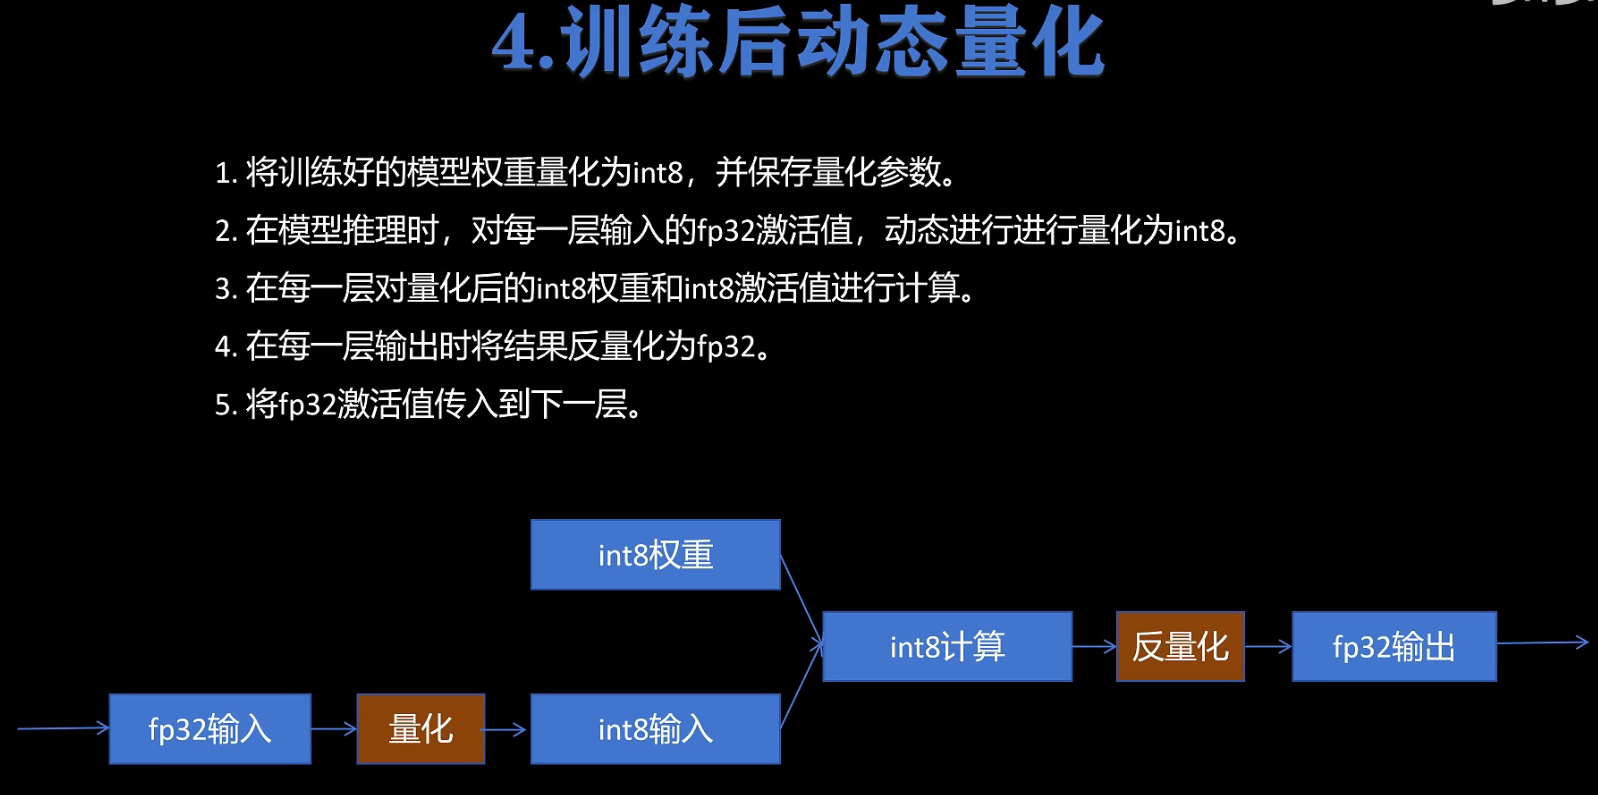  

动态量化的“动态”是指： 激活值（即上图中的fp32输入）是在推理开始后动态量化的，而不像权重（即上图中的int8权重）一样在推理开始之前已经量化过了。  
对于动态量化，模型权重在执行推理之前已经被量化成了int8。开始执行推理后，每一层的输入（即激活值）是fp32的，在与int8的权重做乘法之前，需要“动态”（根据激活值的具体数值）计算激活值的scale和zero_point等量化参数，然后将激活值转换成int8，这就是"动态"量化名字的由来。  

动态量化包括2个阶段：  
（1）量化时将权重量化为int8。  
（2）推理时，输入的激活值是fp32的，动态计算激活对应的scale, zero_point等量化参数，然后将激活值量化为init8，再与int8的权重相乘。  
（3）输出时，将输出从int8反量化为float32。  

与之对比的是静态量化：  
（1）静态量化多一个校准阶段，在校准阶段输入一些代表性input数据，用于统计激活值的最大/最小值，计算激活值的scale, zero_point等量化参数。  
（2）然后是量化阶段，将权重量化为int8，同时保存了激活值的scale, zero_point等量化参数。  
（3）开始推理时，输入的激活值是fp32的，但因为已经有了scale, zero_point等量化参数，可以直接将激活值转换为int8，这样就节省了推理时间。  
（4）输出时，将输出从int8反量化为float32。  

综上所述，动态量化和静态量化的主要区别是激活值的scale, zero_point等量化参数是推理时动态计算的还是在校准阶段已经计算好了。权重都是事先量化成了int8。  

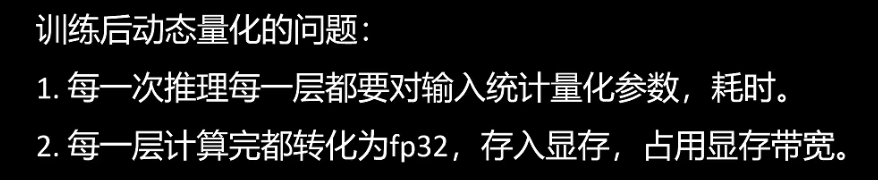

In [1]:
import torch

torch.manual_seed(123)

class MyModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = torch.nn.Linear(3, 3, bias=False)
        self.relu = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(3, 1, bias=False)

    def forward(self, inputs):
        outputs = self.linear1(inputs)
        outputs = self.relu(outputs)
        outputs = self.linear2(outputs)
        return outputs

In [2]:
model = MyModel()

In [3]:
# linear1线性层的in_features为3，out_features为3，所以其权重是形状为(3, 3)的矩阵，权重内容如下：
#model.linear1.weight.data
#model.linear1.weight
#model.linear1.weight.dtype
#model.linear1.weight.data.dtype

print(model.linear1.weight.dtype)
print(model.linear1.weight.shape)
print(model.linear1.weight)

torch.float32
torch.Size([3, 3])
Parameter containing:
tensor([[-0.2354,  0.0191, -0.2867],
        [ 0.2177, -0.4919,  0.4232],
        [-0.4196, -0.4590, -0.3648]], requires_grad=True)


In [4]:
# linear2线性层的in_features为3, out_features为1，所以其权重是形状为(1, 3)的矩阵，权重内容如下：
print(model.linear2.weight.dtype)
print(model.linear2.weight.shape)
print(model.linear2.weight)

torch.float32
torch.Size([1, 3])
Parameter containing:
tensor([[ 0.2615, -0.2133,  0.2161]], requires_grad=True)


In [5]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [6]:
# 构造训练数据

# weights是一个3行1列的矩阵
weights = torch.tensor([[1.1], [2.2], [3.3]])
print(weights.shape)

# training_features是一个12000行3列的矩阵，代表12000个样本，每个样本有3个特征值。
training_features = torch.randn(12000, 3)
print(training_features.shape)

# 训练样本与权重做矩阵乘法，得到training_labels，其形状为(12000, 1)
training_labels = training_features @ weights
print(training_labels.shape)

torch.Size([3, 1])
torch.Size([12000, 3])
torch.Size([12000, 1])


In [7]:
# 构造测试数据

# 测试数据集形状为(1000, 3)
test_features = torch.randn(1000, 3)
print(test_features.shape)

# 测试数据集标签形状为(1000, 1)
test_labels = test_features @ weights
print(test_labels.shape)

torch.Size([1000, 3])
torch.Size([1000, 1])


In [8]:
# 打印训练前model的权重值
print(model.linear1.weight.data)
print(model.linear2.weight.data)

tensor([[-0.2354,  0.0191, -0.2867],
        [ 0.2177, -0.4919,  0.4232],
        [-0.4196, -0.4590, -0.3648]])
tensor([[ 0.2615, -0.2133,  0.2161]])


In [9]:
for i in range(100):
    preds = model(training_features)
    loss = torch.nn.functional.mse_loss(preds, training_labels)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

In [10]:
# 打印训练后model的权重值
print(model.linear1.weight.data)
print(model.linear2.weight.data)

tensor([[ 0.7387,  1.4585,  2.1794],
        [-0.7526, -1.5223, -2.0909],
        [-0.4093, -0.6998, -1.4874]])
tensor([[ 1.5144, -1.1728, -0.5789]])


In [11]:
# 评估float32模型
model.eval()
with torch.no_grad():
    preds = model(test_features)
    mse = torch.nn.functional.mse_loss(preds, test_labels)
    print(f"float32 model testing loss: {mse.item():.3f}")

float32 model testing loss: 0.001


In [12]:
# 量化模型到int8
model_int8 = torch.ao.quantization.quantize_dynamic(
    model, {torch.nn.Linear}, dtype=torch.qint8
)

In [13]:
# 打印模型参数
print("float32 model linear1 parameter:\n", model.linear1.weight)
print("\nint8 model linear1 parameter (int8):\n", torch.int_repr(model_int8.linear1.weight()))

# 查看量化后模型的权重及量化参数。
# 从打印结果可以看到，量化参数scale，zero_point和权重值都保存在了model_int8.linear1.weight()中，方便进行反量化。
print("\nint8 model linear1 parameter:\n", model_int8.linear1.weight())

float32 model linear1 parameter:
 Parameter containing:
tensor([[ 0.7387,  1.4585,  2.1794],
        [-0.7526, -1.5223, -2.0909],
        [-0.4093, -0.6998, -1.4874]], requires_grad=True)

int8 model linear1 parameter (int8):
 tensor([[  43,   85,  127],
        [ -44,  -89, -122],
        [ -24,  -41,  -87]], dtype=torch.int8)

int8 model linear1 parameter:
 tensor([[ 0.7350,  1.4529,  2.1708],
        [-0.7521, -1.5213, -2.0854],
        [-0.4102, -0.7008, -1.4871]], size=(3, 3), dtype=torch.qint8,
       quantization_scheme=torch.per_tensor_affine, scale=0.017093205824494362,
       zero_point=0)


In [14]:
# 使用动态量化的模型进行推理时，权重是int8的，激活值（输入）是fload32的，需要动态计算激活值的scale, zero_point等量化参数，然后才能对激活值进行量化。这也是“动态”量化名字的由来。

print(test_features.data.dtype)

# 评估 int8 模型
with torch.no_grad():
    preds = model_int8(test_features)
    mse = torch.nn.functional.mse_loss(preds, test_labels)
    print(f"int8 model testing loss: {mse.item():.3f}")


torch.float32
int8 model testing loss: 0.006
